In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from util import *
import re
import clip
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import List, Tuple

In [3]:
example_data = np.load("./dataset/sketchrnn_angel.full.npz", encoding='latin1', allow_pickle=True)

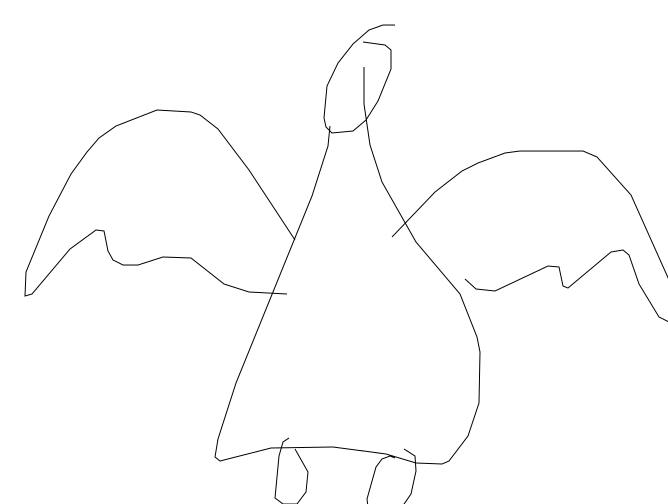

In [4]:
draw_strokes(example_data['train'][0], factor=1)

In [5]:
def encode_stroke_data(stroke_data: np.array, pad_length=None):
    # Going from [x, y, lift_pen] to [delta_x, delta_y, pen_on_paper, pen_off_paper, finished]
    new_doodle = np.zeros((stroke_data.shape[0], 5))
    
    # Handling delta_x, delta_y
    new_row = np.zeros((1, 3))
    temp = np.vstack([new_row, stroke_data])
    new_doodle[:, :2] = temp[1:, :2] - temp[:-1, :2]
    
    # Handling pen_on_paper and pen_off_paper
    new_doodle[:, 2] = stroke_data[:, 2] == 0
    new_doodle[:, 3] = stroke_data[:, 2] == 1

    # Handling finished
    new_doodle[-1, 2] = 0 
    new_doodle[-1, 3] = 0 
    new_doodle[-1, 4] = 1
    
    if pad_length is not None and new_doodle.shape[0] < pad_length:
        padding = np.zeros((pad_length - new_doodle.shape[0], 5))
        padding[:, 4] = 1  # Set finished flag to 1 for padding
        new_doodle = np.vstack([new_doodle, padding])

    return new_doodle

def decode_stroke_data(stroke_data: np.array):
    # Going from [delta_x, delta_y, pen_on_paper, pen_off_paper, finished] to [x, y, lift_pen]
    new_doodle = np.zeros((stroke_data.shape[0], 3))
    new_doodle[:, :2] = np.cumsum(stroke_data[:, :2], axis=0)    
    new_doodle[:, 2] = np.logical_or(stroke_data[:, 3], stroke_data[:, 4])
    return new_doodle

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
clip_model, _ = clip.load("ViT-B/32", device=device)

In [8]:
class DoodleDataset(Dataset):
    def __init__(self, data_dir: Path, split: str, block_size: int):
        self.data_dir = data_dir
        self.block_size = block_size
        self.data = {}
        self.class_embeddings = {}
        
        print("Preprocessing Data:")
        for filepath in tqdm(self.data_dir.glob("*.npz")):
            class_name = self._extract_class_name(filepath)
            class_doodles = self._extract_data(filepath, split, pad_length=self.block_size + 1) # Pad to block_size + 1 because we need x and y        
            self.data[class_name] = class_doodles
        
        print("Calculating CLIP Embeddings")
        class_names = list(self.data.keys())
        tokenized_classnames = clip.tokenize(class_names)
        with torch.no_grad():
            text_features = clip_model.encode_text(tokenized_classnames.to(device))
        
        for class_name, class_features in zip(class_names, text_features):
            self.class_embeddings[class_name] = class_features

        self.class_order_counts = []
        self.class_doodle_lengths = {} # Key = classname, Value = List[int], # blocks
        for class_name, class_doodles in self.data.items():
            self.class_doodle_lengths[class_name] = [(idx, self.get_num_blocks(doodle)) for idx, doodle in enumerate(class_doodles)]
            num_blocks_in_doodles = sum(i[1] for i in self.class_doodle_lengths[class_name])
            self.class_order_counts.append((class_name, num_blocks_in_doodles))
        
        print("Class Order counts:", self.class_order_counts)
        print("Class Doodle lengths:", self.class_doodle_lengths["apple"][:10])
            
    def get_num_blocks(self, doodle):
        return doodle.shape[0] - self.block_size
    
    def __len__(self):
        return sum(i[1] for i in self.class_order_counts)

    def get_category_from_index(self, idx: int, category_list: List[Tuple]):
        for category, count in category_list:
            idx -= count
            if idx < 0:
                return category, idx + count
        return category_list[-1][0], idx

    def __getitem__(self, idx):
        assert idx < len(self), f"Index {idx} out of bounds with length {len(self)}!"
        
        # Get the class name
        class_name, idx_remainder = self.get_category_from_index(idx, self.class_order_counts)
        # print("Class name:", class_name)
        
        # Get the doodle index
        # print("Postprocessed idx:", idx_remainder)
        doodle_index, block_idx = self.get_category_from_index(idx_remainder, self.class_doodle_lengths[class_name])
         
        # print("Doodle index:", doodle_index)
        # print("Block idx:", block_idx)
        
        # Extract the block
        full_doodle = self.data[class_name][doodle_index]
        # print("Full doodle length:", full_doodle.shape)
        
        x = full_doodle[block_idx : block_idx + self.block_size]
        y = full_doodle[block_idx + 1 : block_idx + self.block_size + 1]
        classname_embedding = self.class_embeddings[class_name]
        
        return torch.from_numpy(x), torch.from_numpy(y), classname_embedding 

    def _extract_class_name(self, file: Path):
        # Example filename: `sketchrnn_apple.full.npz`
        pattern = r"sketchrnn_([^.]+)\.full\.npz"
        match = re.match(pattern, file.name)
        assert match, f"Regex for detecting classname failed on {file}"        
        return match.group(1)

    def _extract_data(self, file: Path, split: str, pad_length: int):
        assert split in ["train", "test", "valid"], f"Split {split} is not one of: train, test, valid!"

        raw_data = np.load(file, encoding='latin1', allow_pickle=True)[split]
        encoded_doodles = []
        for doodle in raw_data:
            encoded_doodles.append(encode_stroke_data(doodle, pad_length=pad_length))
        
        return encoded_doodles

train_dataset = DoodleDataset(Path("./dataset"), split="train", block_size=31)
train_dataloader = DataLoader(train_dataset, batch_size=32)

# test_dataset = DoodleDataset(Path("./dataset"), split="test")
# test_dataloader = DataLoader(test_dataset, batch_size=256)

Preprocessing Data:


4it [00:12,  3.02s/it]


Calculating CLIP Embeddings


c:\Python310\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Class Order counts: [('angel', 7459128), ('anvil', 693716), ('apple', 1051387), ('axe', 445496)]
Class Doodle lengths: [(0, 12), (1, 1), (2, 2), (3, 17), (4, 1), (5, 1), (6, 3), (7, 31), (8, 12), (9, 2)]


In [9]:
len(train_dataset)

9649727

In [10]:
x, y, classname_embedding = train_dataset[9_000]
x.shape, y.shape, classname_embedding.shape

(torch.Size([31, 5]), torch.Size([31, 5]), torch.Size([512]))

In [11]:
for batch in train_dataloader:
    ex_batch = batch
    break

In [12]:
xs, ys, ex_classname_embeddings = ex_batch
xs, ys, ex_classname_embeddings = xs.to(device), ys.to(device), ex_classname_embeddings.to(device)
xs.shape, ys.shape, ex_classname_embeddings.shape

(torch.Size([32, 31, 5]), torch.Size([32, 31, 5]), torch.Size([32, 512]))

In [13]:
import torch.nn as nn

In [14]:
class DoodlePredictorConfig:
    def __init__(
        self,
        device: str = "cpu",
        stroke_input_size: int = 5,
        stroke_embed_size: int = 512,
        num_attention_heads: int = 32,
        num_transformer_blocks: int = 16,
        transformer_dropout: float = 0.1,
    ):
        self.device = device
        self.stroke_input_size = stroke_input_size
        self.stroke_embed_size = stroke_embed_size
        self.num_attention_heads = num_attention_heads
        self.num_transformer_blocks = num_transformer_blocks
        self.transformer_dropout = transformer_dropout


class DoodlePredictor(nn.Module):
    def __init__(self, config: DoodlePredictorConfig):
        super().__init__()
        self.config = config
        self.stroke_encoder_mlp = StrokeEncoderMLP(
            input_size=self.config.stroke_input_size,
            output_size=self.config.stroke_embed_size,
        ).to(self.config.device)
        
        self.stroke_transformer = StrokeTransformer(
            num_transformer_blocks=self.config.num_transformer_blocks,
            num_attention_heads=self.config.num_attention_heads,
            embed_size=self.config.stroke_embed_size,
            dropout=self.config.transformer_dropout,
        ).to(self.config.device)
        
        self.stroke_decoder = StrokeDecoderMLP(
            input_size=self.config.stroke_embed_size,
            output_size=self.config.stroke_input_size
        )
        
    def forward(self, x: torch.Tensor, classname_embedding: torch.Tensor):
        # x is of shape: (batch_size, block_size - 1, stroke_input_size)
        encoded_strokes = self.stroke_encoder_mlp(x) # (batch_size, block_size - 1, self.stroke_embed_size)
        
        # TODO: Currently this assumes that the CLIP embedding size is the same as self.config.stroke_embed_size
        combined_input = torch.cat((encoded_strokes, classname_embedding.unsqueeze(1)), dim=1) # (batch_size, block_size, self.stroke_embed_size)
        
        transformer_out = self.stroke_transformer(combined_input)
        
        decoded_out = self.stroke_decoder(transformer_out)
        
        return decoded_out[:, 1:, :]


class StrokeTransformer(nn.Module):
    # TODO: Add causal mask
    def __init__(self, num_transformer_blocks: int, num_attention_heads: int, embed_size: int, dropout: float):
        super().__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_size,
            nhead=num_attention_heads,
            dim_feedforward=4 * embed_size,  # Common practice to use 4x embed size
            dropout=dropout,
            batch_first=True
        )
        
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_transformer_blocks
        )
        
        # Layer norm before transformer
        self.layer_norm = nn.LayerNorm(embed_size)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: (batch_size, block_size, embed_size)
        x = self.layer_norm(x)
        return self.transformer(x)


class StrokeEncoderMLP(nn.Module):
    def __init__(self, input_size: int, output_size: int):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        # TODO: Batchnorm, or some type of norm?
        self.net = nn.Sequential(
            nn.Linear(self.input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, self.output_size)
        )

    def forward(self, x):
        return self.net(x)

class StrokeDecoderMLP(nn.Module):
    def __init__(self, input_size: int, output_size: int):
        super().__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        
        self.net = nn.Sequential(
            nn.Linear(self.input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.output_size)
        )
    
    def forward(self, x: torch.Tensor):
        return self.net(x)
        


In [15]:
mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()
softmax = nn.Softmax()

def calculate_loss(predicted: torch.Tensor, y: torch.Tensor, position_coeff: float, pen_state_coeff: float):
    assert predicted.shape == y.shape
    predicted_delta_positions = predicted[:, :, :2]
    actual_delta_positions = y[:, :, :2]
    position_loss = mse_loss(predicted_delta_positions, actual_delta_positions)
    
    predicted_pen_state = softmax(predicted[:, :, 2:])
    actual_pen_state = y[:, :, 2:]
    pen_state_loss = bce_loss(predicted_pen_state, actual_pen_state)
    
    scaled_position_loss = position_coeff * position_loss
    scaled_pen_state_loss = pen_state_coeff * pen_state_loss
    
    print("Position loss =", scaled_position_loss.item())
    print("Pen State loss =", scaled_pen_state_loss.item())
    
    loss = scaled_position_loss + scaled_pen_state_loss
    return loss

In [22]:
doodle_predictor_config = DoodlePredictorConfig()
doodle_predictor = DoodlePredictor(doodle_predictor_config).to(device)

ex_out = doodle_predictor(xs.float(), ex_classname_embeddings.float())

ex_loss = calculate_loss(ex_out.double(), ys, position_coeff=0.00025, pen_state_coeff=0.99975)
ex_loss

Position loss = 1.1795068762925551
Pen State loss = 1.1760341832492627


tensor(2.3555, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

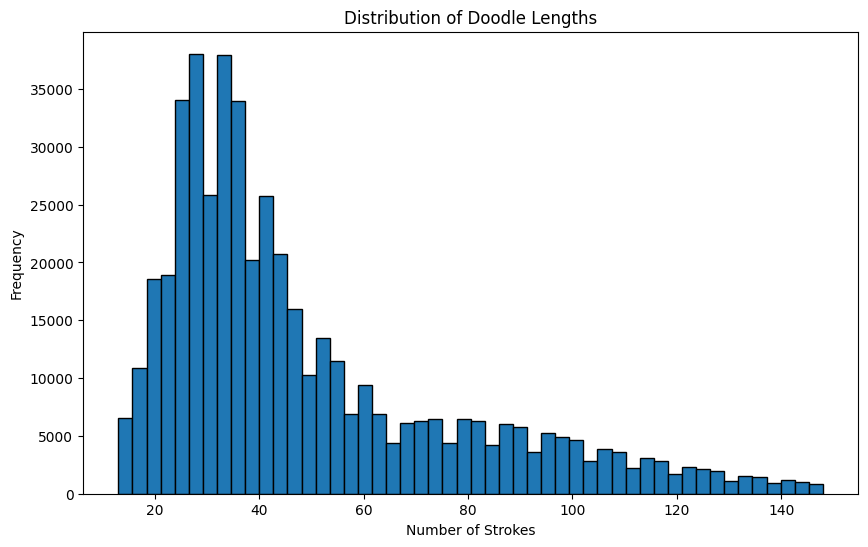

In [37]:
doodle_lengths = [len(train_dataset[i][0]) for i in range(len(train_dataset))]
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(doodle_lengths, bins=50, edgecolor='black')
plt.title('Distribution of Doodle Lengths')
plt.xlabel('Number of Strokes')
plt.ylabel('Frequency')
plt.show()
